In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from rulefit import RuleFit

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format
sns.set()

In [39]:
# load dataset
df = pd.read_csv("bike.csv")
df.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,985,0
1,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,801,1
2,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,1349,2


In [40]:
# dummy encode categorical columns
df = pd.get_dummies(data=df)
df.head(3)

,yr,temp,hum,windspeed,cnt,days_since_2011,season_FALL,season_SPRING,season_SUMMER,season_WINTER,mnth_APR,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,mnth_JUN,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,mnth_SEP,holiday_HOLIDAY,holiday_NO HOLIDAY,weekday_FRI,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,workingday_NO WORKING DAY,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,2011,8.1758,80.5833,10.7499,985,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,2011,9.0835,69.6087,16.6521,801,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
2,2011,1.2291,43.7273,16.6367,1349,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0


In [41]:
# scale data  as RuleFit algorithm will train on Lasso Regression
scale = StandardScaler()
num_cols = ['yr','temp','hum','windspeed']
data = scale.fit_transform(df[num_cols])
data = pd.DataFrame(data,columns=num_cols)
df = pd.concat([df.drop(num_cols,axis=1),data],axis=1,ignore_index=False,sort=False)
df.head(3)

,cnt,days_since_2011,season_FALL,season_SPRING,season_SUMMER,season_WINTER,mnth_APR,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,mnth_JUN,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,mnth_SEP,holiday_HOLIDAY,holiday_NO HOLIDAY,weekday_FRI,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,workingday_NO WORKING DAY,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM,yr,temp,hum,windspeed
0,985,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,-1.0014,-0.8267,1.2502,-0.3879
1,801,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,-1.0014,-0.7211,0.4791,0.7496
2,1349,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,-1.0014,-1.6347,-1.3393,0.7466


In [42]:
# train simple model
y = df['cnt']
x = df.drop('cnt', axis=1)

rf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1,max_depth=3)
rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

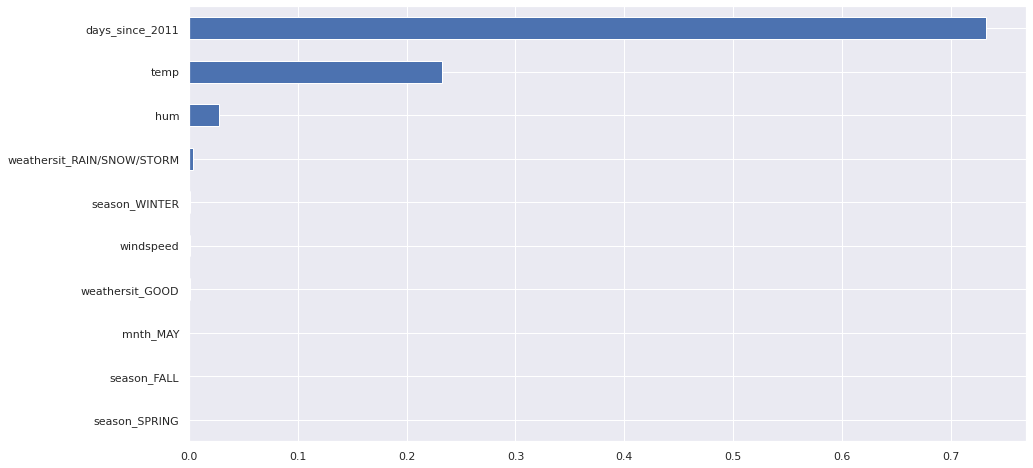

In [43]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(15,8)) 

In [44]:
feat_importances.sum()

1.0

In [45]:
# check rmse
predict = rf.predict(x)
mean_squared_error(y, predict,squared=False)

811.2464715987597

In [46]:
# Create RuleFit
# Default tree_generator is GradientBoosting, but can pass also RandomForest or decision tree
rulefit = RuleFit(tree_generator=RandomForestRegressor(n_estimators = 50,random_state=33,max_depth=3),random_state=56,max_rules=30)
rulefit.fit(x.values, y, feature_names=x.columns)

RuleFit(Cs=None, cv=3, exp_rand_tree_size=True, lin_standardise=True,
        lin_trim_quantile=0.025, max_rules=30, memory_par=0.01, model_type='rl',
        random_state=56, rfmode='regress', sample_fract='default',
        tree_generator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=3,
                                             max_features='auto',
                                             max_leaf_nodes=3, max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=8, n_jobs=None,
                                             oob_score=False, 

In [47]:
predict= rulefit.predict(x.values)
mean_squared_error(y, predict,squared=False)

682.3285396753126

In [48]:
rules = rulefit.get_rules()
rules.sample(5)

,rule,type,coef,support,importance
58,days_since_2011 > 102.0 & days_since_2011 <= 426.0 & temp > -0.14788125455379486,rule,27.8162,0.2882,12.5983
21,weekday_SAT,linear,121.1034,1.0000,42.4738
7,mnth_DEC,linear,-152.3100,1.0000,42.4346
23,weekday_THU,linear,5.8596,1.0000,2.0469
9,mnth_JAN,linear,-189.8200,1.0000,52.8851


In [49]:
rules[rules['type'] == 'rule'].sort_values(by='importance',ascending=False)

,rule,type,coef,support,importance
38,temp > -0.4212189316749573 & days_since_2011 > 434.5,rule,987.8814,0.3034,454.1632
45,days_since_2011 <= 434.5 & days_since_2011 > 98.5 & temp > -0.6489971578121185,rule,460.7281,0.3284,216.3758
54,days_since_2011 <= 434.5 & days_since_2011 <= 105.5,rule,-605.5376,0.1303,203.8719
53,temp > -0.4212189316749573 & days_since_2011 > 426.0 & days_since_2011 > 514.5,rule,383.4801,0.1957,152.1410
42,days_since_2011 > 429.0,rule,281.3450,0.4414,139.7038
59,days_since_2011 <= 434.5 & temp <= -0.2321586161851883,rule,-253.4360,0.3125,117.4707
52,days_since_2011 > 426.0 & temp <= -0.4212189316749573 & hum > 0.48318444192409515,rule,-574.4650,0.0215,83.3329
55,days_since_2011 <= 434.5 & days_since_2011 > 98.5 & temp <= -0.6489971578121185,rule,-94.6446,0.1305,31.8840
47,days_since_2011 <= 426.0 & days_since_2011 <= 102.0 & days_since_2011 <= 43.5,rule,-67.5107,0.0645,16.5854
58,days_since_2011 > 102.0 & days_since_2011 <= 426.0 & temp > -0.14788125455379486,rule,27.8162,0.2882,12.5983


In [50]:
cnt = np.sum((df['temp'] > -0.4212189316749573) & (df['days_since_2011']>434.5))
cnt

226

In [51]:
cnt/df.shape[0]

0.3091655266757866